导包

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math
import random

获取主数据集
test_data 为不可见数据集

In [2]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')
data['isCancerous'] = data['isCancerous'].astype(str)
data['cellType'] = data['cellType'].astype(str)
undivided_train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(undivided_train_data, test_size=0.2, random_state=42)

([0, 1], [Text(0, 0, '0'), Text(1, 0, '1')])

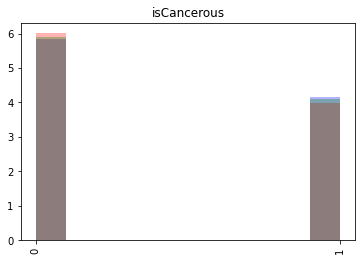

In [3]:
plt.hist(train_data['isCancerous'], alpha=0.3, color='b', label='Train', density=True)
plt.hist(test_data['isCancerous'], alpha=0.3, color='r', label='Test',  density=True)
plt.hist(val_data['isCancerous'], alpha=0.3, color='g', label='Val',  density=True)
plt.title('isCancerous')
plt.xticks(rotation='vertical')

([0, 1, 2, 3],
 [Text(0, 0, '1'), Text(1, 0, '0'), Text(2, 0, '2'), Text(3, 0, '3')])

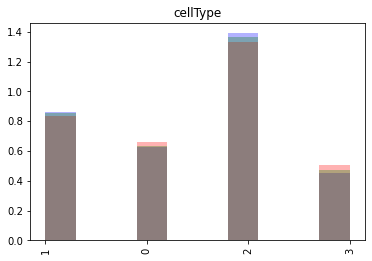

In [4]:
plt.hist(train_data['cellType'], alpha=0.3, color='b', label='Train', density=True)
plt.hist(test_data['cellType'], alpha=0.3, color='r', label='Test',  density=True)
plt.hist(val_data['cellType'], alpha=0.3, color='g', density=True)
plt.title('cellType')
plt.xticks(rotation='vertical')

In [5]:
class_samples_isCancerous = train_data['isCancerous'].value_counts()
total_samples = np.sum(class_samples_isCancerous)
class_weights_isCancerous = total_samples / class_samples_isCancerous
class_weight_dict_isCancerous = {int(k): v for k, v in class_weights_isCancerous.to_dict().items()}

class_samples_cellType = train_data['cellType'].value_counts()
total_samples = np.sum(class_samples_cellType)
class_weights_cellType = total_samples / class_samples_cellType
class_weight_dict_cellType = {int(k): v for k, v in class_weights_cellType.to_dict().items()}

In [71]:
class CustomImageDataGenerator(tf.keras.preprocessing.image.ImageDataGenerator):
    def __init__(self, num_augmentations=3, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_augmentations = num_augmentations

    def apply_transform(self, x, transform_parameters):
        augmentations = [
            "theta",
            "tx",
            "ty",
            "shear",
            "zx",
            "zy",
            "flip_horizontal",
            "flip_vertical",
            "brightness",
        ]

        selected_augmentations = random.sample(augmentations, self.num_augmentations)
        filtered_transform_parameters = {
            key: value for key, value in transform_parameters.items() if key in selected_augmentations
        }

        return super().apply_transform(x, filtered_transform_parameters)

train_datagen = CustomImageDataGenerator(
    num_augmentations=3,
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.2,1.0],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [60]:
batch_size = 32
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='nearest'
# )

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_isCancerous_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary')

val_isCancerous_generator = val_datagen.flow_from_dataframe(
    val_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary')

test_isCancerous_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary')

Found 6332 validated image filenames belonging to 2 classes.
Found 1584 validated image filenames belonging to 2 classes.
Found 1980 validated image filenames belonging to 2 classes.


In [61]:
train_cellType_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

val_cellType_generator = val_datagen.flow_from_dataframe(
    val_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

test_cellType_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

Found 6332 validated image filenames belonging to 4 classes.
Found 1584 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


两层卷积一层池化，32，64。两层512感知器。

In [10]:
input_shape = (27, 27, 3)
num_classes = 4
l2_coeff = 0.01

model_binary = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_binary.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                      

In [62]:
model_categorical = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model_categorical.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 27, 27, 32)        896       
                                                                 
 batch_normalization_24 (Bat  (None, 27, 27, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_25 (Bat  (None, 25, 25, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                      

In [63]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_states()
        self.recall.reset_states()

    def get_config(self):
        return super().get_config()

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [64]:
model_binary.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                     metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       F1Score(name='f1_score')])

model_categorical.compile(loss='categorical_crossentropy',
                          optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005),
                          metrics=['accuracy',
                                   tf.keras.metrics.Precision(name='precision'),
                                   tf.keras.metrics.Recall(name='recall'),
                                   F1Score(name='f1_score')])

In [65]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=3, min_lr=0.5e-15)

In [46]:
epochs = 100
history_binary = model_binary.fit(
    train_isCancerous_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_isCancerous_generator,
    validation_steps=len(val_data) // batch_size,
    class_weight=class_weight_dict_isCancerous
    , callbacks=[lr_reducer]
)

Epoch 1/100
197/197 [==============================] - ETA: 0s - loss: 14.7228 - accuracy: 0.7825 - precision: 0.7098 - recall: 0.8093 - f1_score: 0.7563

/Users/hueybai/miniconda3/envs/DL/lib/python3.10/site-packages/keras/engine/training.py:2448: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


197/197 [==============================] - 10s 44ms/step - loss: 14.7228 - accuracy: 0.7825 - precision: 0.7098 - recall: 0.8093 - f1_score: 0.7563 - val_loss: 14.2416 - val_accuracy: 0.4107 - val_precision: 0.4107 - val_recall: 1.0000 - val_f1_score: 0.5823 - lr: 1.0000e-04
Epoch 2/100
197/197 [==============================] - 8s 42ms/step - loss: 13.4199 - accuracy: 0.8302 - precision: 0.7637 - recall: 0.8569 - f1_score: 0.8076 - val_loss: 12.4927 - val_accuracy: 0.8151 - val_precision: 0.7057 - val_recall: 0.9442 - val_f1_score: 0.8077 - lr: 1.0000e-04
Epoch 3/100
197/197 [==============================] - 8s 43ms/step - loss: 12.3227 - accuracy: 0.8395 - precision: 0.7823 - recall: 0.8528 - f1_score: 0.8160 - val_loss: 11.3814 - val_accuracy: 0.8603 - val_precision: 0.7670 - val_recall: 0.9471 - val_f1_score: 0.8476 - lr: 1.0000e-04
Epoch 4/100
197/197 [==============================] - 8s 41ms/step - loss: 11.3264 - accuracy: 0.8437 - precision: 0.7818 - recall: 0.8667 - f1_score

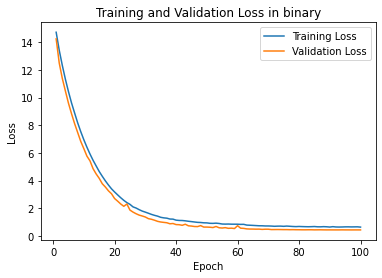

In [47]:
train_loss = history_binary.history['loss']
val_loss = history_binary.history['val_loss']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend()
plt.title('Training and Validation Loss in binary')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

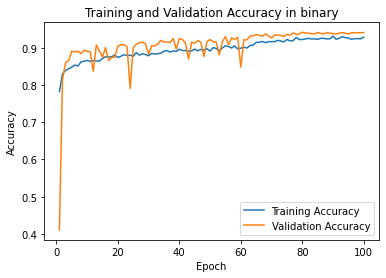

In [48]:
train_accuracy = history_binary.history['accuracy']
val_accuracy = history_binary.history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')

plt.legend()
plt.title('Training and Validation Accuracy in binary')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

评估不可见数据集的表现

In [51]:
model_binary.evaluate(test_isCancerous_generator)

 7/62 [==>...........................] - ETA: 1s - loss: 0.4862 - accuracy: 0.9241 - precision: 0.8889 - recall: 0.9195 - f1_score: 0.9040

/Users/hueybai/miniconda3/envs/DL/lib/python3.10/site-packages/keras/engine/training.py:2448: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


62/62 [==============================] - 2s 26ms/step - loss: 0.4433 - accuracy: 0.9374 - precision: 0.9153 - recall: 0.9292 - f1_score: 0.9222


[0.44328078627586365,
 0.9373737573623657,
 0.9153175354003906,
 0.9292035102844238,
 0.9222081899642944]

# 训练多分类

In [66]:
epochs = 100
history_categorical = model_categorical.fit(
    train_cellType_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_cellType_generator,
    validation_steps=len(val_data) // batch_size,
    class_weight=class_weight_dict_cellType
    , callbacks=[lr_reducer]
)

Epoch 1/100
197/197 [==============================] - 11s 50ms/step - loss: 19.1370 - accuracy: 0.5767 - precision: 0.6084 - recall: 0.5286 - f1_score: 0.5657 - val_loss: 17.3697 - val_accuracy: 0.4107 - val_precision: 0.4107 - val_recall: 0.4107 - val_f1_score: 0.4107 - lr: 5.0000e-04
Epoch 2/100
197/197 [==============================] - 9s 45ms/step - loss: 17.0763 - accuracy: 0.6268 - precision: 0.6707 - recall: 0.5660 - f1_score: 0.6139 - val_loss: 13.7583 - val_accuracy: 0.4968 - val_precision: 0.5421 - val_recall: 0.4681 - val_f1_score: 0.5024 - lr: 5.0000e-04
Epoch 3/100
197/197 [==============================] - 9s 44ms/step - loss: 15.3215 - accuracy: 0.6594 - precision: 0.7079 - recall: 0.5867 - f1_score: 0.6416 - val_loss: 11.5022 - val_accuracy: 0.7315 - val_precision: 0.7775 - val_recall: 0.6620 - val_f1_score: 0.7151 - lr: 5.0000e-04
Epoch 4/100
197/197 [==============================] - 9s 45ms/step - loss: 13.7242 - accuracy: 0.6687 - precision: 0.7246 - recall: 0.600

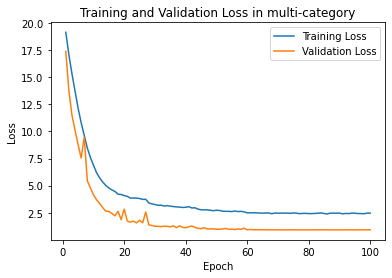

In [68]:
train_loss = history_categorical.history['loss']
val_loss = history_categorical.history['val_loss']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend()
plt.title('Training and Validation Loss in multi-category')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

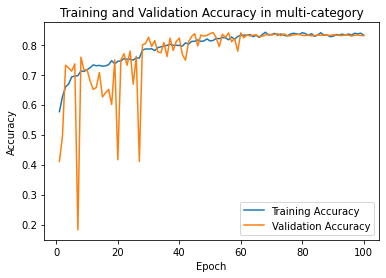

In [69]:
train_accuracy = history_categorical.history['accuracy']
val_accuracy = history_categorical.history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')

plt.legend()
plt.title('Training and Validation Accuracy in multi-category')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [70]:
# # 预测
# predictions = model_categorical.predict(test_cellType_generator)
#
# # 获取预测标签
# predicted_labels = np.argmax(predictions, axis=-1)
#
# # 计算准确度
# true_labels = test_cellType_generator.classes
# accuracy = accuracy_score(true_labels, predicted_labels)
# print(f"Accuracy: {accuracy}")
#
# # 计算损失
# y_true = tf.keras.utils.to_categorical(true_labels, num_classes=4) # 根据您的类别数量更改 num_classes
# loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, predictions))
# print(f"Loss: {loss}")

model_categorical.evaluate(test_cellType_generator)

62/62 [==============================] - 2s 31ms/step - loss: 0.9722 - accuracy: 0.8227 - precision: 0.8440 - recall: 0.7949 - f1_score: 0.8187


[0.9722150564193726,
 0.8227272629737854,
 0.843967854976654,
 0.794949471950531,
 0.8187255263328552]

In [52]:
model_categorical.save('saved_model/model_categorical')

INFO:tensorflow:Assets written to: saved_model/model_categorical/assets


INFO:tensorflow:Assets written to: saved_model/model_categorical/assets


# DI/HD 使用data_labels_extraData对多分类的模型进行增强
通过半监督学习。我们将采用UDA。
首先先获取额外的数据集并且进行相关处理。
我们从数据集可以观察到，没有癌症在多分类中为2。所以我们可以将不是癌症的样本之间指定其多分类的类别为2.

In [53]:
model_categorical = tf.keras.models.load_model('saved_model/model_categorical', custom_objects={"F1Score": F1Score})
data_extra = pd.read_csv('./Image_classification_data/data_labels_extraData.csv')
data_extra['isCancerous'] = data_extra['isCancerous'].astype(str)
# data_extra['cellType'] = np.nan
# data_extra.loc[data_extra['isCancerous'] == '1', 'cellType'] = 2
# data_extra_unlabeled = data_extra[data_extra['cellType'].isna()]
# data_extra_labeled = data_extra[data_extra['cellType'] == 2]
# undivided_train_data = pd.concat([undivided_train_data, data_extra_labeled], axis=0).reset_index(drop=True)
# undivided_train_data['cellType'] = undivided_train_data['cellType'].astype(int)
# train_data, val_data = train_test_split(undivided_train_data, test_size=0.2, random_state=42)

In [22]:
# cellType(多分类)的比例
# class_samples_cellType = train_data['cellType'].value_counts()
# total_samples = np.sum(class_samples_cellType)
# class_weights_cellType = total_samples / class_samples_cellType
# class_weight_dict_cellType = {int(k): v for k, v in class_weights_cellType.to_dict().items()}
#
# data_extra_unlabeled['isCancerous'] = data_extra_unlabeled['isCancerous'].astype(str)
# train_data['cellType'] = train_data['cellType'].astype(str)
# val_data['cellType'] = val_data['cellType'].astype(str)

重新生成新的train_generator

In [54]:
batch_size = 32
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='nearest'
# )
train_datagen = CustomImageDataGenerator(
    num_augmentations=4,
    rescale=1./255,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.2,1.0],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

unlabeled_datagen = CustomImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

unlabeled_generator = unlabeled_datagen.flow_from_dataframe(
    data_extra,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous', # 我们并不关心y_col。只是为了防止报错
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_data['cellType'] = test_data['cellType'].astype(str)
validation_cellType_generator = val_datagen.flow_from_dataframe(
    val_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

Found 6332 validated image filenames belonging to 4 classes.
Found 10384 validated image filenames belonging to 2 classes.
Found 1584 validated image filenames belonging to 4 classes.


## UDA实现

In [24]:
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomFlip("vertical"),
#     tf.keras.layers.RandomRotation(0.1),
#     tf.keras.layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
#     tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
#     tf.keras.layers.RandomContrast(factor=(0.8, 1.2)),
#     tf.keras.layers.RandomBrightness(factor=0.1),
# ])

In [55]:
# 定义数据增强层
class RandAugment(tf.keras.layers.Layer):
    def __init__(self, num_layers, magnitude, **kwargs):
        super().__init__(**kwargs)
        self.num_layers = num_layers
        self.magnitude = magnitude
        self.operations = [
            tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(0.1 * magnitude, 0.1 * magnitude)),
            tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.1 * magnitude, 0.1 * magnitude), width_factor=(-0.1 * magnitude, 0.1 * magnitude)),
            tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.1 * magnitude, 0.1 * magnitude), width_factor=(-0.1 * magnitude, 0.1 * magnitude)),
            tf.keras.layers.experimental.preprocessing.RandomContrast(factor=(1 - 0.1 * magnitude, 1 + 0.1 * magnitude)),
            tf.keras.layers.RandomBrightness(factor=(0.2 * magnitude)),
        ]

    def call(self, inputs, **kwargs):
        if kwargs.get('training'):
            for _ in range(self.num_layers):
                operation = random.choice(self.operations)
                inputs = operation(inputs, training=kwargs.get('training'))
        return inputs

In [56]:
def apply_uda(x_batch, y_batch, x_unlabeled, model, optimizer, training=True, class_weight_dict=None, consistency_weight=1.5, confidence_threshold=0.5, temperature=0.5):
    x_unlabeled_augmented = None
    if x_unlabeled is not None:
        # 对无标签数据进行数据增强
        # x_unlabeled_augmented = data_augmentation(x_unlabeled)
        rand_augment = RandAugment(num_layers=3, magnitude=0.9)
        x_unlabeled_augmented = rand_augment(x_unlabeled, training=training)

    # 计算模型在原始无标签数据和增强无标签数据上的输出
    with tf.GradientTape() as tape:
        y_pred_labeled = model(x_batch)
        if x_unlabeled is not None:
            y_pred_unlabeled = model(x_unlabeled)
            y_pred_unlabeled_augmented = model(x_unlabeled_augmented)

            # Sharpening Predictions
            y_pred_unlabeled = tf.nn.softmax(y_pred_unlabeled / temperature, axis=-1)
            y_pred_unlabeled_augmented = tf.nn.softmax(y_pred_unlabeled_augmented / temperature, axis=-1)

            # Confidence-based masking
            max_probs = tf.reduce_max(y_pred_unlabeled, axis=-1)
            mask = max_probs > confidence_threshold
            y_pred_unlabeled = tf.boolean_mask(y_pred_unlabeled, mask)
            y_pred_unlabeled_augmented = tf.boolean_mask(y_pred_unlabeled_augmented, mask)

        # 计算有监督损失
        # 如果是训练并且给定了类别权重，则根据权重计算损失。
        if class_weight_dict is not None and training:
            sample_weights = tf.gather(class_weight_dict, tf.argmax(y_batch, axis=-1))
            supervised_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_batch, y_pred_labeled) * sample_weights)
        else:
            supervised_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_batch, y_pred_labeled))

        # 如果提供了无标签数据，则计算一致性损失，(半监督学习)
        if x_unlabeled is not None:
            consistency_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_pred_unlabeled, y_pred_unlabeled_augmented))
            total_loss = supervised_loss + consistency_weight * consistency_loss
        else:
            total_loss = supervised_loss

        # 计算准确度
        accuracy = tf.keras.metrics.categorical_accuracy(y_batch, y_pred_labeled)

        # 计算Precision
        precision = tf.keras.metrics.Precision()
        precision.update_state(tf.argmax(y_batch, axis=-1), tf.argmax(y_pred_labeled, axis=-1))

        # 计算Recall
        recall = tf.keras.metrics.Recall()
        recall.update_state(tf.argmax(y_batch, axis=-1), tf.argmax(y_pred_labeled, axis=-1))

        # 计算F1分数
        f1_score = 2 * ((precision.result() * recall.result()) / (precision.result() + recall.result() + tf.keras.backend.epsilon()))

        if training:
            # 反向传播和优化
            grads = tape.gradient(total_loss, model_categorical.trainable_variables)
            optimizer.apply_gradients(zip(grads, model_categorical.trainable_variables))
    return total_loss, supervised_loss, consistency_loss if x_unlabeled is not None else None, accuracy, precision.result(), recall.result(), f1_score

### 训练半监督

In [57]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.1e-5)
epochs = 1
min_val_loss = float('inf')
num_epochs_no_improvement = 0
current_learning_rate = optimizer.learning_rate.numpy()
history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": [], "precision":[],
           "recall":[], "f1":[], "val_precision":[], "val_recall":[], "val_f1":[]}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    total_loss = 0
    total_supervised_loss = 0
    total_consistency_loss = 0
    total_accuracy = 0
    total_precision = 0
    total_recall = 0
    total_f1_score = 0
    steps = 0

    total_batches = math.ceil(len(train_data) / batch_size)
    with tqdm(total=total_batches, desc="Training", ncols=100) as progress_bar:
        for (x_batch, y_batch), (x_unlabeled, _) in zip(train_generator, unlabeled_generator):
            progress_bar.update(1)
            loss, supervised_loss, consistency_loss, accuracy, precision, recall, f1_score = apply_uda(x_batch,
                                                                                                       y_batch,
                                                                                                       x_unlabeled,
                                                                                                       model_categorical,
                                                                                                       optimizer,
                                                                                                       class_weight_dict_cellType)
            total_loss += loss
            total_supervised_loss += supervised_loss
            total_consistency_loss += consistency_loss
            total_precision += precision
            total_recall += recall
            total_f1_score += f1_score
            total_accuracy += tf.reduce_mean(accuracy)
            steps += 1
            # 检查是否已经处理了所有批次
            if steps * batch_size >= len(train_data):
                break

        # 计算并打印平均损失和准确率
        avg_loss = total_loss / steps
        avg_supervised_loss = total_supervised_loss / steps
        avg_consistency_loss = total_consistency_loss / steps
        avg_accuracy = total_accuracy / steps
        avg_precision = total_precision / steps
        avg_recall = total_recall / steps
        avg_f1_score = total_f1_score / steps

        history["loss"].append(avg_loss.numpy())
        history["accuracy"].append(avg_accuracy.numpy())
        history["precision"].append(avg_precision.numpy())
        history["recall"].append(avg_recall.numpy())
        history["f1"].append(avg_f1_score.numpy())
        print(f" - loss: {avg_loss.numpy():.4f}, supervised_loss: {avg_supervised_loss.numpy():.4f}, consistency_loss: {avg_consistency_loss.numpy():.4f}, accuracy: {avg_accuracy.numpy():.4f}, precision: {avg_precision.numpy():.4f}, recall: {avg_recall.numpy():.4f}, f1_score: {avg_f1_score.numpy():.4f}")

    total_loss = 0
    total_accuracy = 0
    steps = 0
    for x_batch, y_batch in validation_cellType_generator:
        loss, _, _, accuracy, precision, recall, f1_score = apply_uda(x_batch, y_batch, None, model_categorical, optimizer, False)
        total_loss += loss
        total_precision += precision
        total_recall += recall
        total_f1_score += f1_score
        total_accuracy += tf.reduce_mean(accuracy)
        steps += 1

        if steps * batch_size >= len(test_data):
            break

    avg_loss = total_loss / steps
    avg_accuracy = total_accuracy / steps
    avg_precision = total_precision / steps
    avg_recall = total_recall / steps
    avg_f1_score = total_f1_score / steps

    history["val_loss"].append(avg_loss.numpy())
    history["val_accuracy"].append(avg_accuracy.numpy())
    history["val_precision"].append(avg_precision.numpy())
    history["val_recall"].append(avg_recall.numpy())
    history["val_f1"].append(avg_f1_score.numpy())
    print(f"Validation set： - loss: {avg_loss.numpy():.4f}, supervised_loss: {avg_supervised_loss.numpy():.4f}, consistency_loss: {avg_consistency_loss.numpy():.4f}, accuracy: {avg_accuracy.numpy():.4f}, precision: {avg_precision.numpy():.4f}, recall: {avg_recall.numpy():.4f}, f1_score: {avg_f1_score.numpy():.4f}")

    # 检查是否需要更新学习率
    if avg_loss < min_val_loss:
        min_val_loss = loss
        num_epochs_no_improvement = 0
    else:
        num_epochs_no_improvement += 1

    if num_epochs_no_improvement >= 3:
        current_learning_rate *= np.sqrt(0.1)
        current_learning_rate = max(current_learning_rate, 0.5e-15)
        optimizer.learning_rate.assign(current_learning_rate)
        num_epochs_no_improvement = 0

Epoch 1/1


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:27<00:00,  7.30it/s]


 - loss: 0.4826, supervised_loss: 0.3858, consistency_loss: 0.0646, accuracy: 0.8583, precision: 0.9592, recall: 0.9505, f1_score: 0.9541
Validation set： - loss: 0.4316, supervised_loss: 0.3858, consistency_loss: 0.0646, accuracy: 0.8362, precision: 3.9996, recall: 4.0047, f1_score: 3.9989


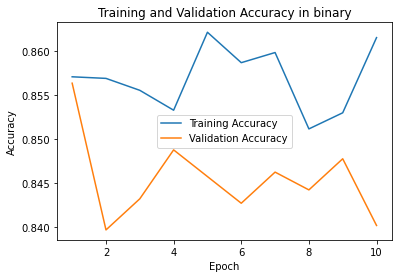

In [32]:
train_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')

plt.legend()
plt.title('Training and Validation Accuracy in binary')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [58]:
model_categorical.evaluate(test_cellType_generator)

62/62 [==============================] - 2s 29ms/step - loss: 0.9280 - accuracy: 0.8242 - precision: 0.8495 - recall: 0.7980 - f1_score: 0.8229


[0.9280155897140503,
 0.8242424130439758,
 0.8494623899459839,
 0.7979797720909119,
 0.8229166865348816]